<a href="https://colab.research.google.com/github/TejasKDA/Melanoma-detection-Assignment/blob/main/Tejas_Kumar_D_A_nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

**Importing Skin Cancer Data**

To do: Take necessary actions to read the data

**Importing all the important libraries**

In [ ]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


In [ ]:
from glob import glob

Mount Google drive for getting Train and test images

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:

# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


**Load using keras.preprocessing**

Let's load these images off disk using the helpful image_dataset_from_directory utility.

**Create a dataset**

Define some parameters for the loader:

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [ ]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
#Generates a tf.data.Dataset from the image files in the directory.
train_ds = tf.keras.utils.image_dataset_from_directory(
            data_dir_train,
            batch_size=batch_size,
            image_size=(img_height, img_width),
            seed=123,
            validation_split=0.2,
            subset='training',
            )##todo

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [ ]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
#Generates a tf.data.Dataset from the image files in the directory.
val_ds = tf.keras.utils.image_dataset_from_directory(
            data_dir_train,
            batch_size=batch_size,
            image_size=(img_height, img_width),
            seed=123,
            validation_split=0.2,
            subset='validation',
            )##todo

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [ ]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


**Visualize the data**

Todo, create a code to visualize one instance of all the nine classes present in the dataset

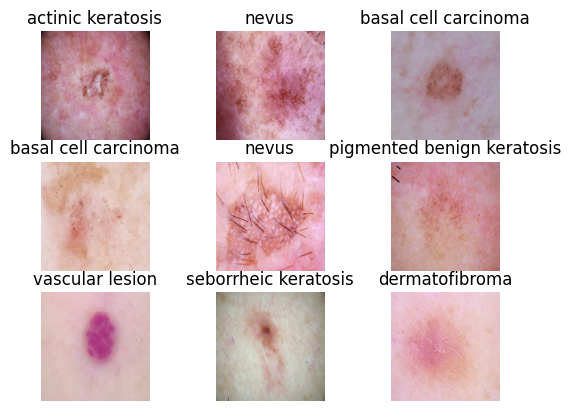

In [ ]:
### your code goes here, you can use training or validation data to visualize
import matplotlib.pyplot as plt
for i in range(len(class_names)):
    filtered_ds = train_ds.filter(lambda x, l: tf.math.equal(l[0], i))
    for image, label in filtered_ds.take(1):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(image[i].numpy().astype('uint8'))
        plt.title(class_names[label.numpy()[i]])
        plt.axis('off')

The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch.

Dataset.prefetch() overlaps data preprocessing and model execution while training.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

**Create the model**

Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use layers.experimental.preprocessing.Rescaling to normalize pixel values between (0,1). The RGB channel values are in the [0, 255] range. This is not ideal for a neural network. Here, it is good to standardize values to be in the [0, 1]

In [ ]:
### Your code goes here
#The Keras sequence class helps create a layer cluster that is linearly stacked into a tf. keras. Model.
num_class = 9
model = tf.keras.Sequential([
    layers.Rescaling(scale = 1./255, input_shape = (180,180,3)),
    layers.Conv2D(16,3,padding='same',activation= 'relu'),
    layers.MaxPooling2D(pool_size = 2, strides = 2),
    layers.Conv2D(32,3,padding='same',activation= 'relu'),
    layers.MaxPooling2D(pool_size = 2, strides = 2),
    layers.Conv2D(64,3,padding='same',activation= 'relu'),
    layers.MaxPooling2D(pool_size = 2, strides = 2),
    layers.Flatten(),
    layers.Dense(128,activation='relu'),
    layers.Dense(num_class)
])

**Compile the model**

Choose an appropirate optimiser and loss function for model training

In [ ]:
### Todo, choose an appropirate optimiser and loss function
#loss: Sparse Categorical Crossentropy Calculates the crossentropy loss between labels and predictions.
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics=['accuracy'])

In [ ]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

**Train the model**

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 199s 3s/step - loss: 2.0530 - accuracy: 0.2221 - val_loss: 1.9316 - val_accuracy: 0.2908
Epoch 2/20
56/56 [==============================] - 1s 21ms/step - loss: 1.8446 - accuracy: 0.3175 - val_loss: 1.7428 - val_accuracy: 0.3289
Epoch 3/20
56/56 [==============================] - 1s 20ms/step - loss: 1.6765 - accuracy: 0.3962 - val_loss: 1.5559 - val_accuracy: 0.4743
Epoch 4/20
56/56 [==============================] - 1s 20ms/step - loss: 1.4738 - accuracy: 0.4810 - val_loss: 1.4060 - val_accuracy: 0.5056
Epoch 5/20
56/56 [==============================] - 1s 21ms/step - loss: 1.4439 - accuracy: 0.5000 - val_loss: 1.3963 - val_accuracy: 0.5369
Epoch 6/20
56/56 [==============================] - 1s 22ms/step - loss: 1.2853 - accuracy: 0.5485 - val_loss: 1.5349 - val_accuracy: 0.4497
Epoch 7/20
56/56 [==============================] - 1s 22ms/step - loss: 1.2224 - accuracy: 0.5647 - val_loss: 1.3824 - val_accuracy: 0.5347
Epoch 8/20
56

**Visualizing training results**

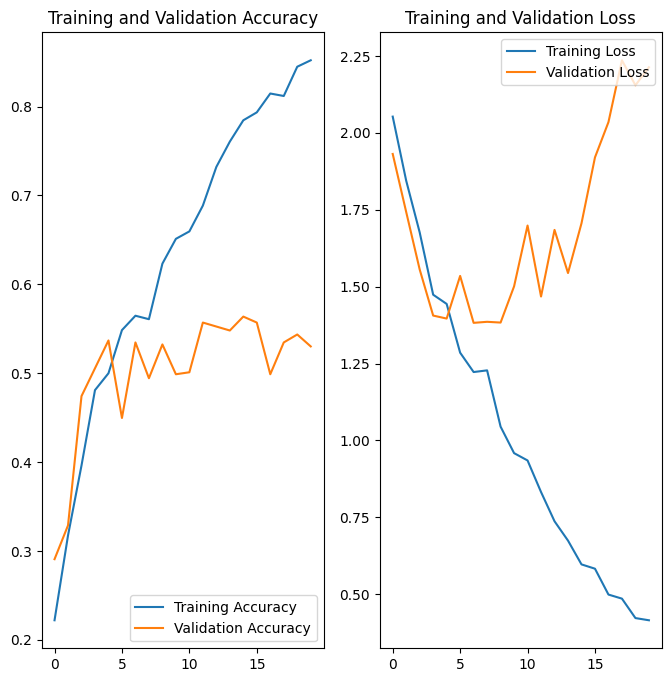

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Todo**: Write your findings after the model fit, see if there is an evidence of model overfit or underfit
Write your findings here


**Findings**:-

The above model is clearly the case of overfitting and the model doesn't seem to be learning anything from the dataset.

   (1) Training accuracy is very high, while validation accuracy is around 50%.

   (2) The loss on the training set decreases after each epoch, but in the case of the validation set, it climbs back again after the 5th epoch.

Instead of generalizing and learning real features and general relationships, the model memorized the data

In [ ]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
# Your code goes here
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
  layers.experimental.preprocessing.RandomZoom(height_factor=(0.2,0.3), width_factor=(0.2,0.3))
])

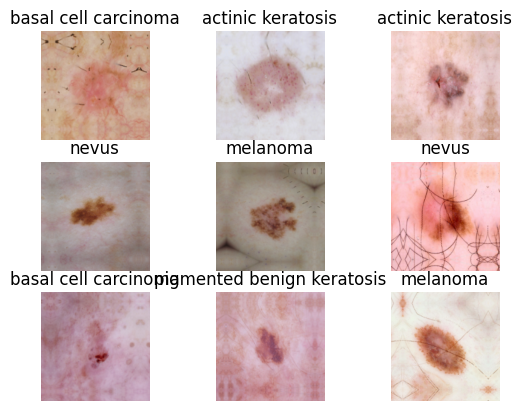

In [ ]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
for img, labels in train_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(data_augmentation(img)[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis("off")

**Todo**:
Create the model, compile and train the model


In [ ]:
## You can use Dropout layer if there is an evidence of overfitting in your findings
## https://www.tensorflow.org/tutorials/images/data_augmentation
## https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/RandomFlip
## Your code goes here
#The Keras sequence class helps create a layer cluster that is linearly stacked into a tf. keras. Model.

num_classes = 9
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.3),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.2),
  layers.Dense(num_classes)
])


**Compiling the model**


In [ ]:

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics=['accuracy'])

**Training the model**

In [ ]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
) ## your training code

Epoch 1/20
56/56 [==============================] - 5s 32ms/step - loss: 2.0715 - accuracy: 0.2109 - val_loss: 1.8731 - val_accuracy: 0.3266
Epoch 2/20
56/56 [==============================] - 2s 28ms/step - loss: 1.8606 - accuracy: 0.3231 - val_loss: 1.7805 - val_accuracy: 0.3781
Epoch 3/20
56/56 [==============================] - 2s 29ms/step - loss: 1.7743 - accuracy: 0.3700 - val_loss: 1.6690 - val_accuracy: 0.3893
Epoch 4/20
56/56 [==============================] - 2s 31ms/step - loss: 1.5082 - accuracy: 0.4743 - val_loss: 1.4311 - val_accuracy: 0.4743
Epoch 6/20
56/56 [==============================] - 2s 30ms/step - loss: 1.4920 - accuracy: 0.4821 - val_loss: 1.4613 - val_accuracy: 0.5324
Epoch 7/20
56/56 [==============================] - 2s 28ms/step - loss: 1.4419 - accuracy: 0.4877 - val_loss: 1.4209 - val_accuracy: 0.5145
Epoch 8/20
56/56 [==============================] - 2s 28ms/step - loss: 1.4240 - accuracy: 0.4967 - val_loss: 1.4146 - val_accuracy: 0.5257
Epoch 9/20
56

**Visualizing the results**

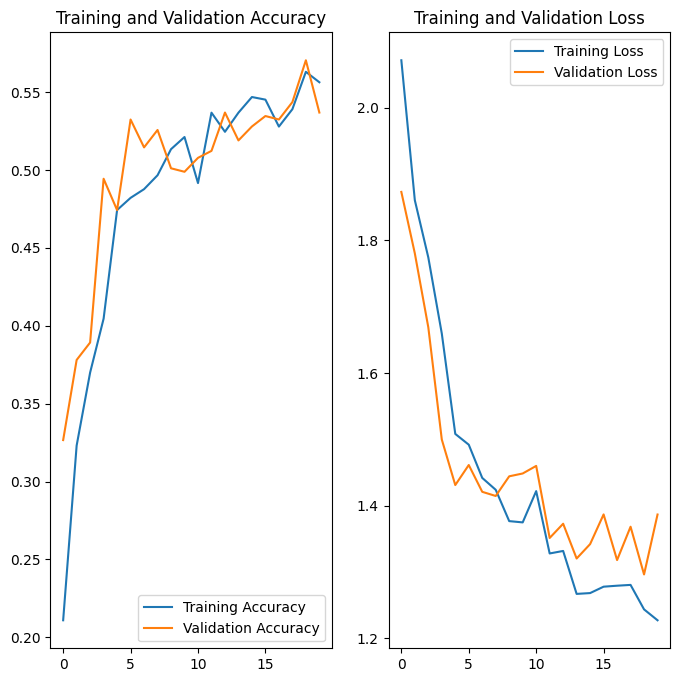

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Todo**:
Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

**Findings**:-

In the above model use of data augmentation and dropout layer reduced the problem of overfitting.

The accuracy of the model has greatly increased along with the synchronization of the verification accuracy. The loss function is synchronously exhausted for the training and validation data.

**Todo**:

**Find the distribution of classes in the training dataset**.

**Context**: Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [ ]:
## Your code goes here.
## original_df - > path_list, lesion_list
path_list=[]
lesion_list=[]

In [ ]:
for i in class_names:
  for j in data_dir_train.glob(i+'/*.jpg'):
    path_list.append(str(j))
    lesion_list.append(i)
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns=['Path','Label'])
original_df

,Path,Label
0,/content/gdrive/MyDrive/CNN_assignment/Skin ca...,actinic keratosis
1,/content/gdrive/MyDrive/CNN_assignment/Skin ca...,actinic keratosis
2,/content/gdrive/MyDrive/CNN_assignment/Skin ca...,actinic keratosis
3,/content/gdrive/MyDrive/CNN_assignment/Skin ca...,actinic keratosis
4,/content/gdrive/MyDrive/CNN_assignment/Skin ca...,actinic keratosis
...,...,...
2234,/content/gdrive/MyDrive/CNN_assignment/Skin ca...,vascular lesion
2235,/content/gdrive/MyDrive/CNN_assignment/Skin ca...,vascular lesion
2236,/content/gdrive/MyDrive/CNN_assignment/Skin ca...,vascular lesion
2237,/content/gdrive/MyDrive/CNN_assignment/Skin ca...,vascular lesion


<BarContainer object of 9 artists>

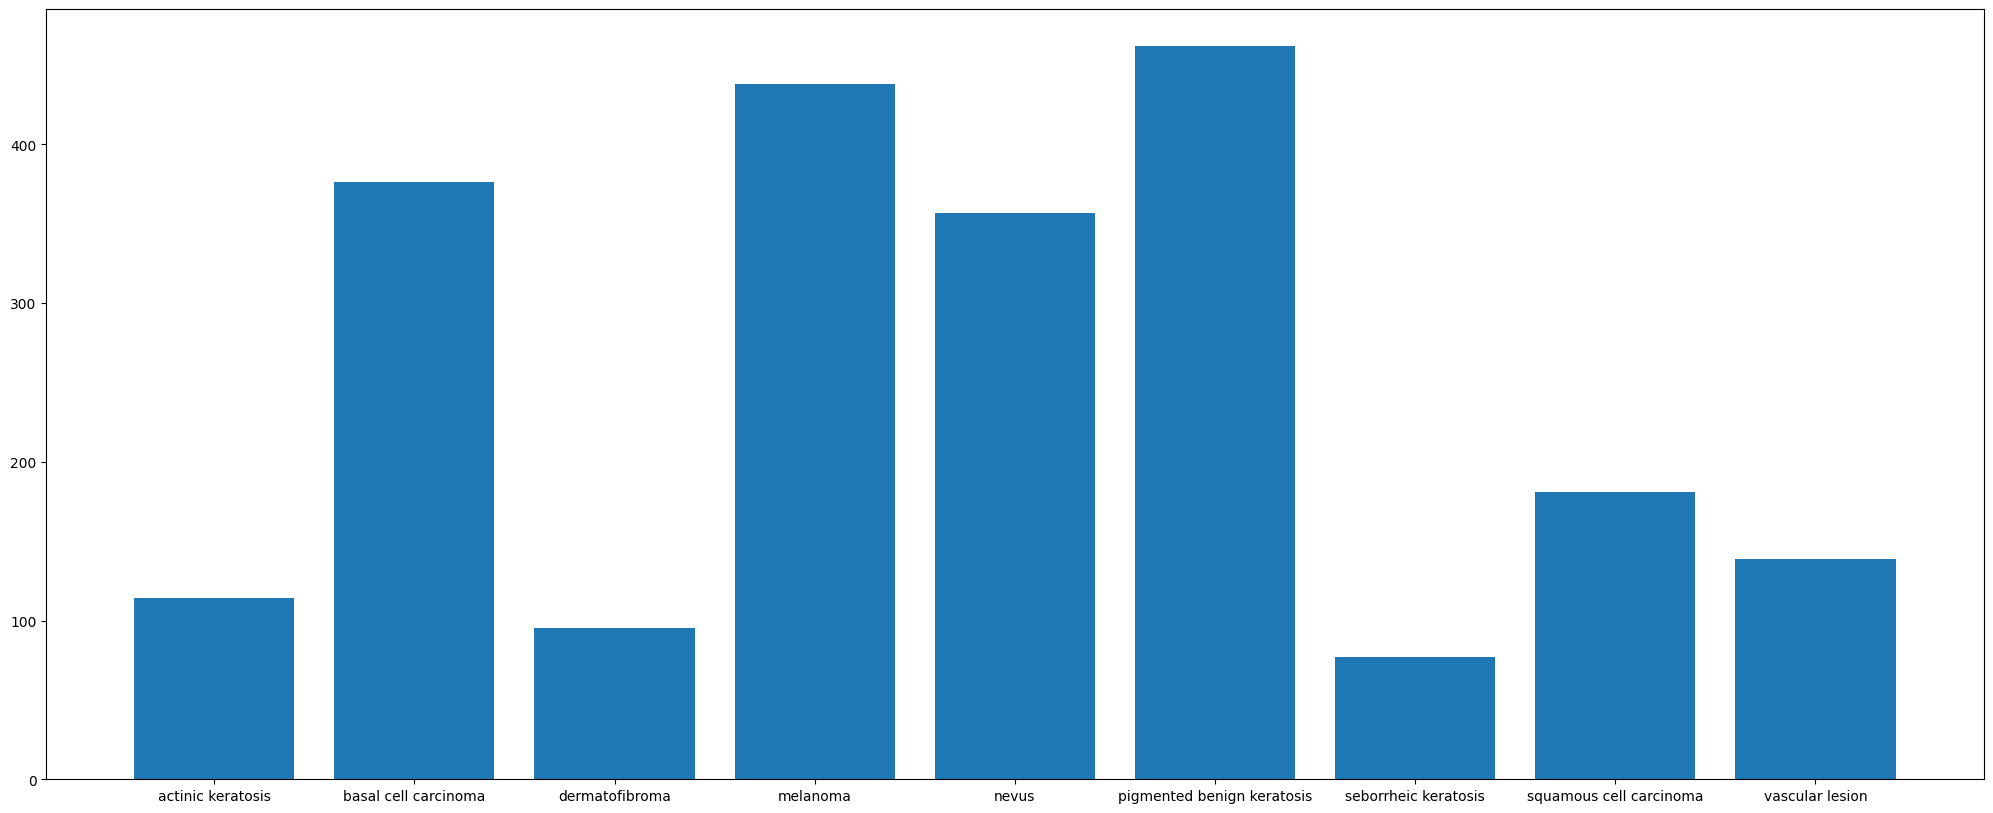

In [ ]:
# glob('./Skin cancer ISIC The International Skin Imaging Collaboration/train/*/*')
# './Skin cancer ISIC The International Skin Imaging Collaboration/train\\actinic keratosis\\ISIC_0025780.jpg'
class_count=[]
for i in class_names:
    class_count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(25,10))
plt.bar(class_names,class_count)

**Todo**: Write your findings here:
- Which class has the least number of samples?
The least number of samples are in seborrheic keratosis

- **Which classes dominate the data in terms proportionate number of samples?**

The classes dominate in the data are:-
* pigmented benign
* melanoma
* basal cell carcinoma
* nevus

**Todo**: **Rectify the class imbalance**

Context: You can use a python package known as Augmentor (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [ ]:
!pip install Augmentor

To use Augmentor, the following general procedure is followed:

1)Instantiate a Pipeline object pointing to a directory containing your initial image data set.

2)Define a number of operations to perform on this data set using your Pipeline object.

3)Execute these operations by calling the Pipeline’s sample() method.

In [ ]:
path_to_training_dataset="/content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability = 0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B96E40B6E60>: 100%|██████████| 500/500 [00:19<00:00, 25.28 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B9665A43C10>: 100%|██████████| 500/500 [00:18<00:00, 26.69 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B96704BB190>: 100%|██████████| 500/500 [00:18<00:00, 26.90 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7B96663B3280>: 100%|██████████| 500/500 [01:27<00:00,  5.72 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B9665A8AEC0>: 100%|██████████| 500/500 [01:19<00:00,  6.27 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B96D01FB010>: 100%|██████████| 500/500 [00:19<00:00, 25.67 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7B96703440A0>: 100%|██████████| 500/500 [00:40<00:00, 12.33 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B96D00D9E10>: 100%|██████████| 500/500 [00:19<00:00, 25.55 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B96D00824A0>: 100%|██████████| 500/500 [00:20<00:00, 24.13 Samples/s]


In [ ]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


**Lets see the distribution of augmented data after adding new images to the original training data.**

In [ ]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027536.jpg_522bf607-d2a1-4c10-a68a-24ae1b6a9dc1.jpg',
 '/content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0025992.jpg_b38b7e27-e31e-405a-8a22-792ead8db093.jpg',
 '/content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030142.jpg_95eddb31-a6e1-4602-a0c0-96199d264870.jpg',
 '/content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030133.jpg_b349c2fa-db3c-425d-84a6-9a08afe5db9c.jpg',
 '/content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic

In [ ]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [ ]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [ ]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])


new_df =pd.concat([original_df,df2], ignore_index=True)

In [ ]:

new_df['Label'].value_counts()

Label
pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: count, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

**Todo**: Train the model on the data created using Augmentor

In [ ]:
batch_size = 32
img_height = 180
img_width = 180


**Todo**: Create a training dataset

In [ ]:
data_dir_train="/content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
                                  data_dir_train,
                                  seed=123,
                                  validation_split = 0.2,
                                  subset = 'training',## Todo choose the correct parameter value, so that only training data is refered to,,
                                  image_size=(img_height, img_width),
                                  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


**Todo**: Create a validation dataset

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
                                  data_dir_train,
                                  seed=123,
                                  validation_split = 0.2,
                                  subset = 'validation',## Todo choose the correct parameter value, so that only validation data is refered to,
                                  image_size=(img_height, img_width),
                                  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


**Todo**: Create your model (make sure to include normalization)

In [ ]:
## your code goes here
num_classes = 9
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.3),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.2),
  layers.Dense(num_classes)
])

**Todo**: Compile your model (Choose optimizer and loss function appropriately)

In [ ]:
## your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

**Todo**: Train your model

In [ ]:
epochs = 30
## Your code goes here, use 50 epochs.
history30 = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)# your model fit cod

Epoch 1/30
169/169 [==============================] - 47s 258ms/step - loss: 2.0174 - accuracy: 0.2333 - val_loss: 1.6849 - val_accuracy: 0.3615
Epoch 2/30
169/169 [==============================] - 43s 249ms/step - loss: 1.6342 - accuracy: 0.3722 - val_loss: 1.4927 - val_accuracy: 0.4105
Epoch 3/30
169/169 [==============================] - 41s 237ms/step - loss: 1.5334 - accuracy: 0.4160 - val_loss: 1.4263 - val_accuracy: 0.4425
Epoch 4/30
169/169 [==============================] - 46s 266ms/step - loss: 1.4824 - accuracy: 0.4308 - val_loss: 1.3867 - val_accuracy: 0.4417
Epoch 5/30
169/169 [==============================] - 45s 258ms/step - loss: 1.4285 - accuracy: 0.4407 - val_loss: 1.3614 - val_accuracy: 0.4566
Epoch 6/30
169/169 [==============================] - 51s 297ms/step - loss: 1.4142 - accuracy: 0.4501 - val_loss: 1.4061 - val_accuracy: 0.4306
Epoch 7/30
169/169 [==============================] - 44s 251ms/step - loss: 1.3649 - accuracy: 0.4714 - val_loss: 1.3049 - val_ac

**Todo**: Visualize the model results

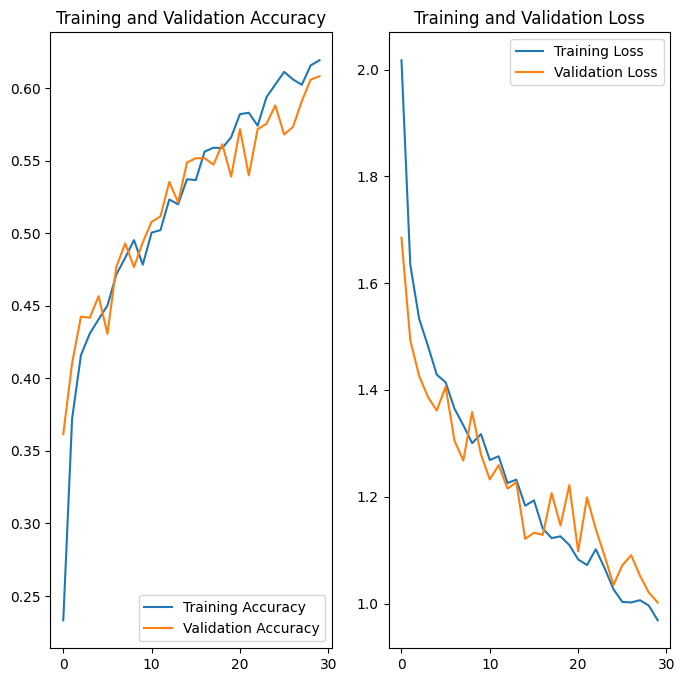

In [ ]:
acc = history30.history['accuracy']
val_acc = history30.history['val_accuracy']

loss = history30.history['loss']
val_loss = history30.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Todo: Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?**

The problem of overfitting and underfitting was solved and the model was well trained for predictions. Data augmentation, outliers, and class equalization were found to be useful in improving model performance in this case.